# Stock trading with Pandas

Inspired by an example given by James Powell in the Q&A session for his talk [How to Be a Pandas Expert][1] from PyData 2021.

[1]: https://www.youtube.com/watch?v=oazUQPrs8nw

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import string
import datetime as dt

In [3]:
from tqdm import tqdm

## Randomly generate stock-market-ish data

Our exceptionally well-ordered synthetic stock market has a few listings with ticker symbols 'a', 'b', 'c'...

In [4]:
m = 12
n = 1000

Create our own random number generator for reproducible randomness. I picked a seed that gives a nice spread of high and low performing shares.

In [5]:
rng = np.random.default_rng(seed=1004)

In [6]:
tickers = list(string.ascii_lowercase[0:m])

In [7]:
dates = [dt.date(2019, 1, 1) + dt.timedelta(days=i) for i in range(n+1)]

This pleasantly concise expression gives our stock price data. 

The top row gives every listing a starting price of 100. We then fill out the matrix by adding normally distributed random movement to an underlying linear trend. We take the cumulative sum down the columns to get daily price. The linspace vector representing the trend is weighted positively toward the beginning of the alphabet and negatively toward the end, but our stock picker algorithm won't know that.

In [8]:
prices = pd.DataFrame(
    data=np.concatenate([
        (np.ones((1,m)) * 100),
        rng.normal(scale=1, size=(n, m)) + np.linspace(+25/n, -25/n, m)
    ], axis=0).cumsum(axis=0),
    columns=tickers,
    index=dates
)
prices

,a,b,c,d,e,f,g,h,i,j,k,l
2019-01-01,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2019-01-02,100.038640,99.957740,100.265067,100.060948,101.189484,101.407207,100.002849,99.718696,100.439544,98.922916,100.249751,98.974275
2019-01-03,100.567770,99.628441,100.777709,99.599538,101.117073,102.728638,100.348299,99.634569,100.378592,98.971862,98.203577,99.353196
2019-01-04,101.037346,100.630074,101.851512,97.748191,102.013415,103.058314,99.881321,100.189234,101.642883,99.671835,98.676520,99.930480
2019-01-05,100.632124,101.650043,102.792831,97.041718,101.244709,102.945009,98.237284,101.814980,101.411525,98.625733,98.009942,99.212947
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,142.672957,119.600920,187.928752,96.670816,166.460186,145.356993,71.644486,98.049276,82.662922,41.892147,88.048914,77.728052
2021-09-24,141.284375,119.589481,187.919152,97.211565,167.070296,146.920951,70.472725,98.978681,82.183171,40.883765,90.056949,77.933212
2021-09-25,139.848834,119.870665,188.015275,99.253153,167.607173,146.110266,72.834574,99.841670,81.988523,40.560570,89.198908,78.237215
2021-09-26,139.366828,120.823919,189.523844,99.815003,170.078150,145.282282,74.394581,97.210534,81.943180,40.598512,89.431420,78.448641


In [9]:
prices.iloc[1000, :].sum() / m

110.58263107933915

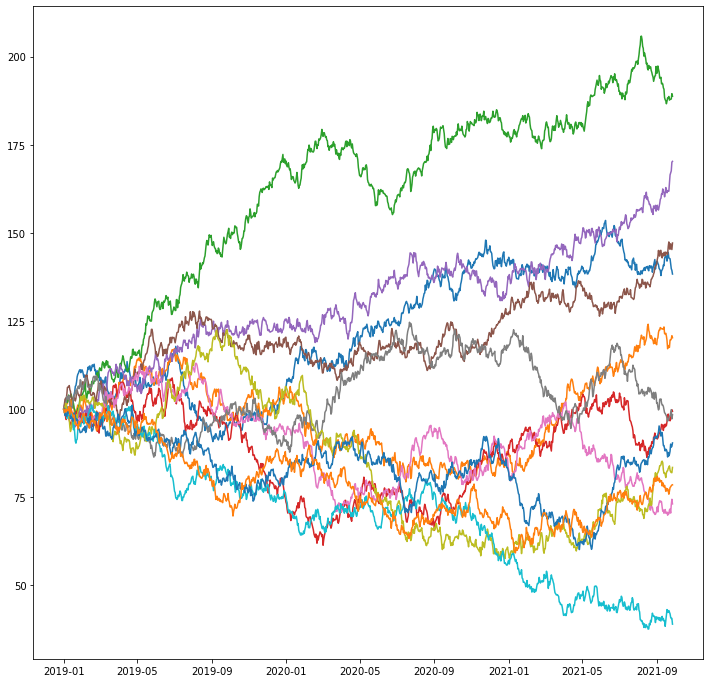

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
p = plt.plot(prices)

## Random day-trader (long positions only)

Randomly buy or sell something every day.

We implement this as a Python loop. Trading is a "stateful" operation. At each step, we need to consider our current holdings and our cash balance so we know what we can buy and sell.

If anyone knows of a way to achieve a similar effect through the Pandas API, let me know. Also, if anyone knows of a trading strategy that reliably picks only winners, send that my way, too.

In [11]:
def random_day_trader(starting_balance, prices, rng=None):
    
    dates = prices.index
    tickers = prices.columns

    # cash balance on each day
    cash_balance = pd.Series(np.zeros(n+1), index=dates)
    cash_balance.iloc[0] = starting_balance

    # holdings on each day represented as number of shares in each stock
    holdings = pd.DataFrame(
        data=np.zeros((n+1,m)),
        columns=tickers,
        index=dates,
    )

    prev_i = prices.index[0]
    for i, row in prices[1:].iterrows():
#         print('-'*90)
#         print(i)
        holdings.loc[i,:] = holdings.loc[prev_i,:]
        to_buy = (np.floor(cash_balance[prev_i] / row / 100) * 100).astype(int)
        to_sell = holdings.loc[i,:] * -1

#         print('to_buy\n', to_buy)
#         print('to_sell\n', to_sell)

        # Candidates is a Series representing stocks that we might buy or sell. The index
        # is the ticker symbol and the value is a randomly selected number of shares where
        # positive represents buying and and negatives represent selling in lots of 100.
        # We can buy only if we have enough cash and sell only shares we own.
        #
        # random.Generator.triangular(left, mode, right, size=None)
        # requires right > left
        idx = to_buy > to_sell
        candidates = pd.Series(
            (np.floor( rng.uniform(to_sell[idx], to_buy[idx]) / 100 ) * 100).astype(int),
            index=idx.index[idx]
        )
        candidates = candidates[candidates.abs() > 0]
#         print('candidates\n', candidates)

        cash_balance[i] = cash_balance[prev_i]

        if candidates.any():

            # pick a stock to buy or sell
            # sample using rng's bit generator for reproducibility
            pick = candidates.sample(n=1, random_state=rng.bit_generator)
#             print('pick', pick)

            ticker = pick.index.values
            price = float(row[ticker])
#             print('price=', price)
            cash_balance[i] -= float(pick * price)
            holdings.loc[i,:][ticker] += pick

#         h = holdings.loc[i,:]
#         print("holdings\n", h[h>0])

        prev_i = i
    
    return cash_balance, holdings

In [12]:
cash_balance, holdings = random_day_trader(100_000, prices, rng)

In [13]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(holdings)

In [14]:
total_value = cash_balance + (holdings * prices).sum(axis=1)
total_value[n]

87389.05802423887

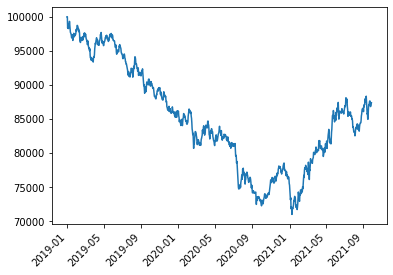

In [15]:
p = plt.plot(total_value)
p = plt.xticks(rotation=45, ha='right')

In [16]:
day_trader_results = [random_day_trader(100_000, prices, rng) for i in tqdm(range(100))]

100%|██████████| 100/100 [04:01<00:00,  2.42s/it]


In [17]:
def total_value(cash_balance, holdings, prices):
    return cash_balance + (holdings * prices).sum(axis=1)

In [18]:
day_traders = pd.DataFrame({
    f"trader_{i:02}": total_value(*x, prices) for i,x in enumerate(day_trader_results)
})
day_traders.shape

(1001, 100)

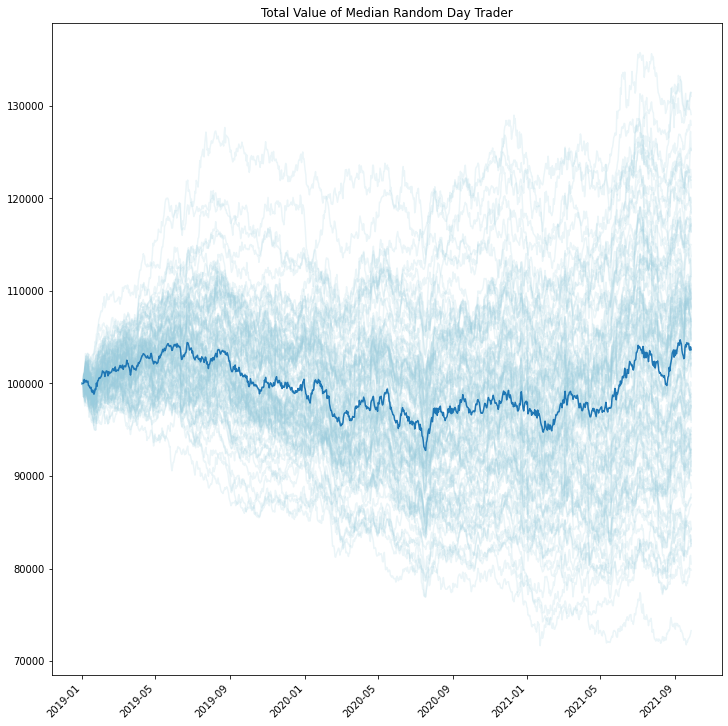

In [19]:
fig, ax = plt.subplots(figsize=(12,12))
p = plt.plot(day_traders, color="#99ccdd30")
p = plt.plot(day_traders.median(axis=1))
p = plt.xticks(rotation=45, ha='right')
p = plt.title("Total Value of Median Random Day Trader")

### Don't buy the cheap stuff

Why do 100 traders on average do worse than the market? Picking buys and sells as I did leads to a bias towards shares with lower share price. And, because the underlying trend is linear, stocks that go down tend to keep going down. Buying what you can afford and buying in fixed lots of 100 both increase the probability of buying cheaper shares.

In [20]:
day_traders.iloc[1000,:].describe()

count       100.000000
mean     103085.793098
std       12444.087862
min       73308.987915
25%       93444.388678
50%      103653.819220
75%      109925.890444
max      131436.427505
Name: 2021-09-27, dtype: float64

In [21]:
total_holdings = sum(x[1]*prices for x in day_trader_results)
total_holdings.shape

(1001, 12)

<AxesSubplot:>

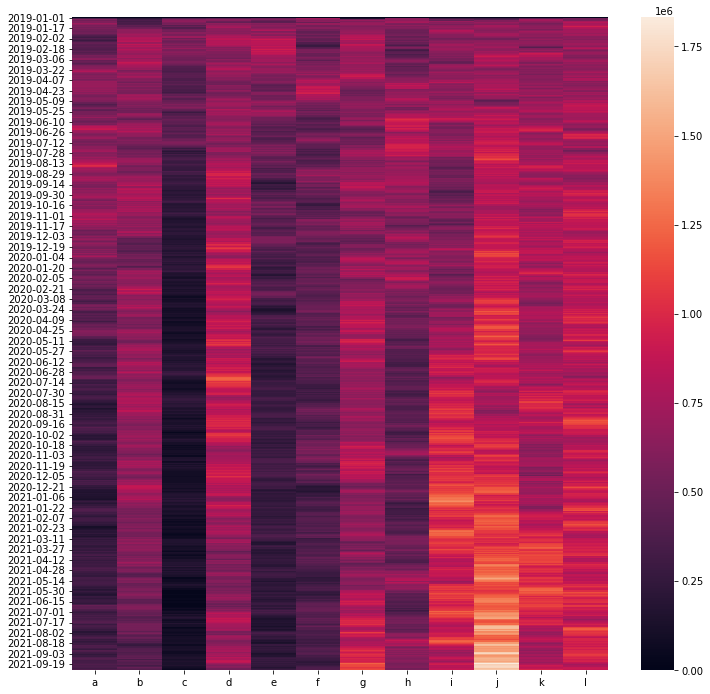

In [22]:
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(total_holdings, annot=False, linewidths=0, ax=ax)

In [23]:
prices.iloc[[n]]

,a,b,c,d,e,f,g,h,i,j,k,l
2021-09-27,138.326463,120.260406,188.802544,99.386281,170.312008,147.138464,73.085683,98.396502,83.436615,38.949245,90.393903,78.503457


## Random day trading, take 2

Still only long positions, but selecting stock with uniform probability and then number of shares to buy or sell within the limits of cash and holdings. Seems to result in a more even pattern of holdings.

In [24]:
def random_day_trader(starting_balance, prices, rng=None):
    
    dates = prices.index
    tickers = prices.columns

    # cash balance on each day
    cash_balance = pd.Series(np.zeros(n+1), index=dates)
    cash_balance.iloc[0] = starting_balance

    # holdings on each day represented as number of shares in each stock
    holdings = pd.DataFrame(
        data=np.zeros((n+1,m)),
        columns=tickers,
        index=dates,
    )

    prev_i = prices.index[0]
    for i, row in prices[1:].iterrows():
#         print('-'*90)
#         print(i)
        holdings.loc[i,:] = holdings.loc[prev_i,:]
        cash_balance[i] = cash_balance[prev_i]

        ticker = rng.choice(tickers, size=1)
        price = float(row[ticker])
        max_amount = cash_balance[prev_i] / price
        current_holding = holdings.loc[i,:][ticker]
        amount = np.floor(rng.uniform(-current_holding, max_amount)).astype(int)

        cash_balance[i] -= float(amount * price)
        holdings.loc[i,:][ticker] += amount

        h = holdings.loc[i,:]
#         print("holdings\n", h[h>0])
#         print("cash_balance", cash_balance[i])

        prev_i = i
    
    return cash_balance, holdings

In [25]:
cash_balance, holdings = random_day_trader(100_000, prices, rng)

In [26]:
day_trader_results = [random_day_trader(100_000, prices, rng) for i in tqdm(range(100))]

100%|██████████| 100/100 [1:10:47<00:00, 42.47s/it]  


In [27]:
day_traders = pd.DataFrame({
    f"trader_{i:02}": total_value(*x, prices) for i,x in enumerate(day_trader_results)
})
day_traders.shape

(1001, 100)

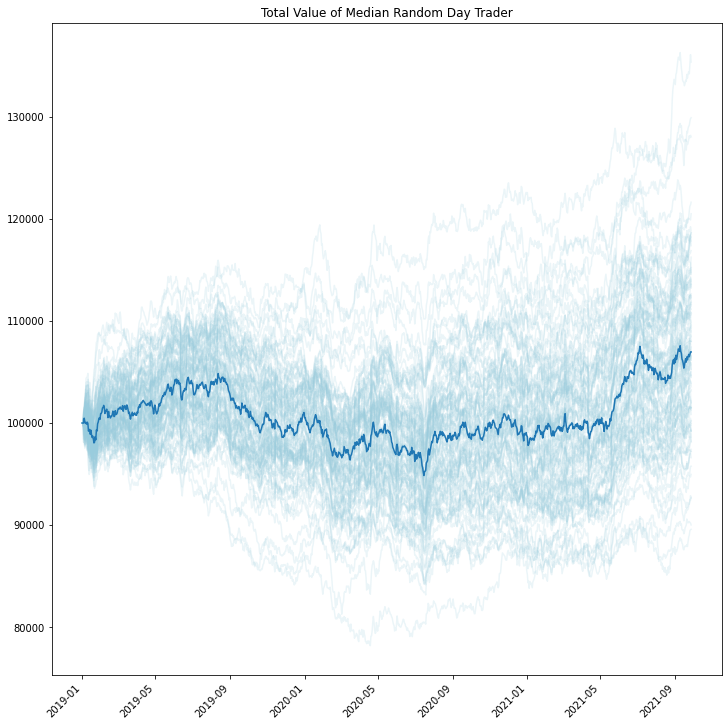

In [28]:
fig, ax = plt.subplots(figsize=(12,12))
p = plt.plot(day_traders, color="#99ccdd30")
p = plt.plot(day_traders.median(axis=1))
p = plt.xticks(rotation=45, ha='right')
p = plt.title("Total Value of Median Random Day Trader")

In [29]:
day_traders.iloc[1000,:].describe()

count       100.000000
mean     107409.470499
std        8279.728506
min       89589.359586
25%      101511.672731
50%      106964.248302
75%      112529.269757
max      135338.110594
Name: 2021-09-27, dtype: float64

In [30]:
total_holdings = sum(x[1]*prices for x in day_trader_results)
total_holdings.shape

(1001, 12)

<AxesSubplot:>

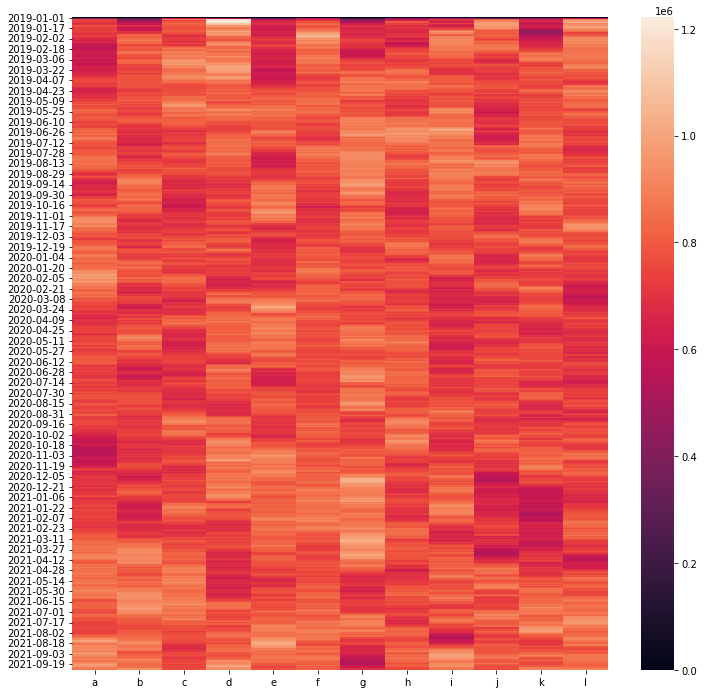

In [31]:
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(total_holdings, annot=False, linewidths=0, ax=ax)

## Momentum

If our fake data is built on the idea that each stock has a constant underlying trend with daily noise, momentum investing should work.

In [32]:
prices_ma = (
    prices
    .pct_change(1)
    .fillna(0.0)
    .rolling(100, min_periods=1)
    .mean()
)

In [33]:
prices_ma

,a,b,c,d,e,f,g,h,i,j,k,l
2019-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-02,0.000193,-0.000211,0.001325,0.000305,0.005947,0.007036,0.000014,-0.001407,0.002198,-0.005385,0.001249,-0.005129
2019-01-03,0.001892,-0.001239,0.002588,-0.001334,0.003726,0.009034,0.001161,-0.001219,0.001263,-0.003425,-0.005971,-0.002143
2019-01-04,0.002586,0.001584,0.004605,-0.005647,0.005011,0.007578,-0.000293,0.000478,0.004096,-0.000801,-0.003274,-0.000155
2019-01-05,0.001267,0.003295,0.005532,-0.005963,0.002502,0.005843,-0.003526,0.003627,0.002822,-0.002740,-0.003970,-0.001560
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,-0.000407,0.000725,-0.000226,-0.000348,0.001088,0.001194,-0.001424,-0.001319,0.001602,-0.000247,0.001673,0.000413
2021-09-24,-0.000574,0.000609,-0.000272,-0.000348,0.001106,0.001341,-0.001687,-0.001319,0.001576,-0.000187,0.002048,0.000623
2021-09-25,-0.000698,0.000732,-0.000296,-0.000340,0.001150,0.001313,-0.001412,-0.001392,0.001730,-0.000458,0.001781,0.000381
2021-09-26,-0.000699,0.000795,-0.000251,-0.000175,0.001269,0.001114,-0.001505,-0.001807,0.001688,-0.000496,0.001860,0.000494


### Check our work

That was too easy. Is that really the 100-day moving averages? I don't trust it. Let's double check.

In [34]:
z = pd.DataFrame(
    data=np.concatenate([
        np.zeros((1,m)),
        (prices.values[1:n+1] - prices.values[0:n]) / prices.values[0:n]
    ]),
    columns=tickers,
    index=dates
)

In [35]:
np.mean(z.a)

0.0003579813568601208

In [36]:
ma_100_of_a = [np.mean(z.a[max(0,i-99):min(n+1,i)]) for i in range(0,n+1)]

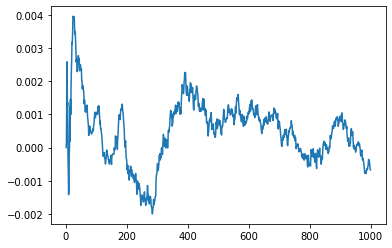

In [37]:
p = plt.plot(ma_100_of_a)

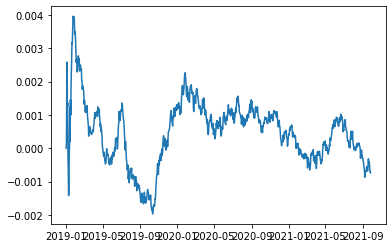

In [38]:
p = plt.plot(prices_ma.a)

OK, that checks out...

### Back to Momentum

In [39]:
def momentum_investor(starting_balance, prices, prices_ma, rng=None):

    dates = prices.index
    tickers = prices.columns

    # cash balance on each day
    cash_balance = pd.Series(np.zeros(n+1), index=dates)
    cash_balance.iloc[0] = starting_balance

    # holdings on each day represented as number of shares in each stock
    holdings = pd.DataFrame(
        data=np.zeros((n+1,m)),
        columns=tickers,
        index=dates,
    )

    prev_i = prices.index[0]
    for i, row in prices[1:].iterrows():
#         print('-'*90)
#         print(i)
        holdings.loc[i,:] = holdings.loc[prev_i,:]
        cash_balance[i] = cash_balance[prev_i]

        # find listing with most momentum
        ticker_positive = prices_ma.loc[i,:].idxmax()

        # find listing with most abs momentum
        ticker_abs = prices_ma.loc[i,:].abs().idxmax()

        if ticker_positive != ticker_abs and holdings.loc[i,ticker_abs] > 0:
            ticker = ticker_abs
            price = float(row[ticker])
            current_holding = holdings.loc[i,:][ticker]
            amount = np.floor(rng.uniform(-current_holding, 0)).astype(int)
        else:
            ticker = ticker_positive
            price = float(row[ticker])
            max_amount = cash_balance[prev_i] / price
            amount = np.floor(rng.uniform(0, max_amount)).astype(int)

        cash_balance[i] -= float(amount * price)
        holdings.loc[i,:][ticker] += amount

        h = holdings.loc[i,:]
#         print("holdings\n", h[h>0])
#         print("cash_balance", cash_balance[i])

        prev_i = i
    
    return cash_balance, holdings

In [40]:
cash_balance, holdings = momentum_investor(100_000, prices, prices_ma, rng)

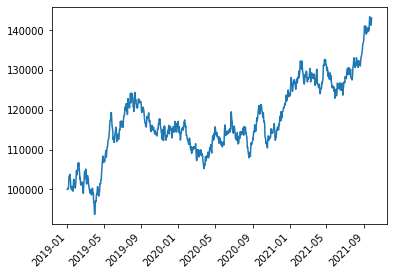

In [41]:
p = plt.plot(total_value(cash_balance, holdings, prices))
p = plt.xticks(rotation=45, ha='right')

### Random momentum trader

There's not enough randomness here to make a population of traders interesting. Instead of always picking the stock with highest or most negative momentum, lets sample weighted by momentum.

In [42]:
def random_momentum_investor(starting_balance, prices, prices_ma, rng=None):

    dates = prices.index
    tickers = prices.columns

    # cash balance on each day
    cash_balance = pd.Series(np.zeros(n+1), index=dates)
    cash_balance.iloc[0] = starting_balance

    # holdings on each day represented as number of shares in each stock
    holdings = pd.DataFrame(
        data=np.zeros((n+1,m)),
        columns=tickers,
        index=dates,
    )

    prev_i = prices.index[0]
    for i, row in prices[1:].iterrows():
#         print('-'*90)
#         print(i)
        holdings.loc[i,:] = holdings.loc[prev_i,:]
        cash_balance[i] = cash_balance[prev_i]

        # sample a listing with upward momentum
        ma_up = prices_ma.loc[i,:].where(lambda x: x > 0, 0)
        ticker_up = ma_up.sample(n=1, weights=ma_up).index[0] if ma_up.sum() > 0 else None

        # sample a listing we own with downward momentum
        ma_down = prices_ma.loc[i,:].where(lambda x: x <0, 0)[holdings.loc[i,:] > 0]
        ticker_down = ma_down.sample(n=1, weights=ma_down).index[0] if ma_down.sum() > 0 else None

        if ticker_down and (not ticker_up or ma_down.abs()[ticker_down] > ma_up[ticker_up]):
            ticker = ticker_down
            price = float(row[ticker])
            current_holding = holdings.loc[i,:][ticker]
            amount = np.floor(rng.uniform(-current_holding, 0)).astype(int)
        elif ticker_up:
            ticker = ticker_up
            price = float(row[ticker])
            max_amount = cash_balance[prev_i] / price
            amount = np.floor(rng.uniform(0, max_amount)).astype(int)
        else:
            continue

        cash_balance[i] -= float(amount * price)
        holdings.loc[i,:][ticker] += amount

        h = holdings.loc[i,:]
#         print("holdings\n", h[h>0])
#         print("cash_balance", cash_balance[i])

        prev_i = i
    
    return cash_balance, holdings

In [43]:
momentum_results = [random_momentum_investor(100_000, prices, prices_ma, rng) for i in tqdm(range(100))]

100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


In [44]:
momentum_traders = pd.DataFrame({
    f"trader_{i:02}": total_value(*x, prices) for i,x in enumerate(momentum_results)
})
momentum_traders.shape

(1001, 100)

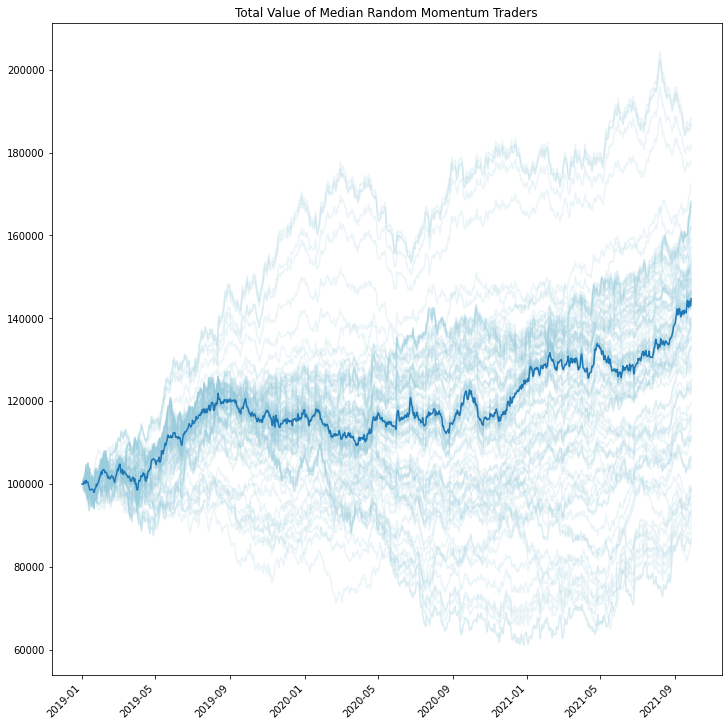

In [45]:
fig, ax = plt.subplots(figsize=(12,12))
p = plt.plot(momentum_traders, color="#99ccdd30")
p = plt.plot(momentum_traders.median(axis=1))
p = plt.xticks(rotation=45, ha='right')
p = plt.title("Total Value of Median Random Momentum Traders")